## Preprocessing

In [10]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,roc_curve,auc,f1_score,confusion_matrix

import gensim
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('SpamVsHam.tsv', delimiter='\t', header=None, names=['Label', 'Message'])
print(df.head())
print("Shape : ", df.shape, "\n")
print(df.info())
print("\n Class distribution :", df['Label'].value_counts())

##?? we should have 4827 ham data, right? At least the pdf says.

  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Shape :  (5572, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

 Class distribution : Label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
## preprocess
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    text = ' '.join(tokens)
    return text

df['Message'] = df['Message'].apply(preprocess)

print("Cleaned text:", df.head())

Cleaned text:   Label                                            Message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry 2 wkly comp win fa cup final tkts 2...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


## Feature Extraction Techniques

In [4]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Message']).toarray()

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (5572, 5000)


In [5]:
#Word2Vec
TokenTexts = df['Message'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=TokenTexts, vector_size=100, window=5, min_count=1, workers=2)
#Try relatively default parameters for word2vec.

def vectorize(text, model):
    vector = np.zeros(model.vector_size)
    n_words = 0

    for word in word_tokenize(text):
        if word in model.wv:
            vector += model.wv[word]
            n_words += 1

    if n_words > 0:
        vector /= n_words 
    return vector

X_word2vec = np.array([vectorize(text, word2vec_model) for text in df['Message']])
print("Word2Vec shape:", X_word2vec.shape)

Word2Vec shape: (5572, 100)


## Modeling: Random Forest (TF-IDF)

In [7]:
X = X_tfidf  
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
print("Unique labels after conversion:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
print("Unique classes in y_train:", unique_classes_train)
print("Unique classes in y_test:", unique_classes_test) 

Unique labels after conversion: [0 1]
Unique classes in y_train: [0 1]
Unique classes in y_test: [0 1]


In [8]:
rf_classifier = RandomForestClassifier(n_estimators=37, criterion = 'entropy', random_state=1)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#estimator= 100 => 97.67%
#estimator= 37 => 97.67%

Accuracy: 0.9736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1448
           1       1.00      0.80      0.89       224

    accuracy                           0.97      1672
   macro avg       0.99      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672



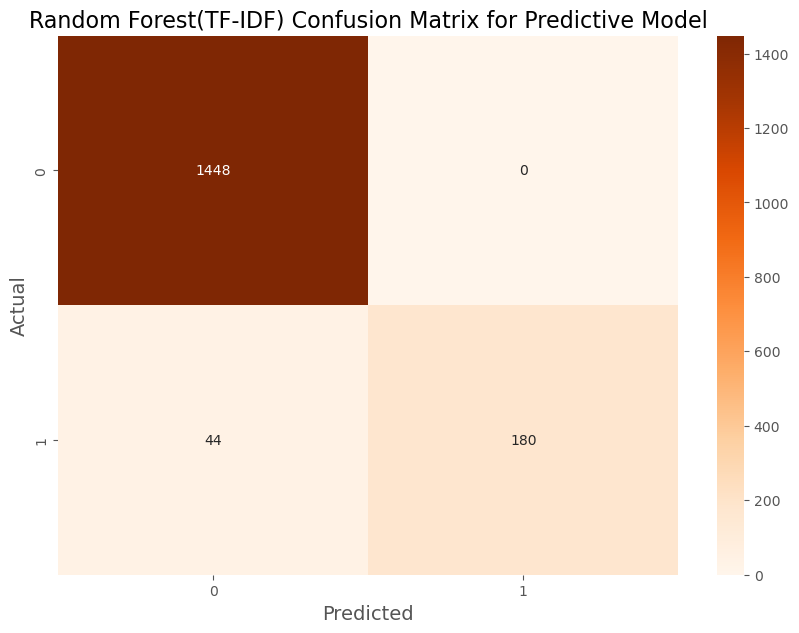

0.9736842105263158

In [13]:
cm = confusion_matrix(y_test, y_pred)


# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Oranges', fmt='g')
plt.title('Random Forest(TF-IDF) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

In [54]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

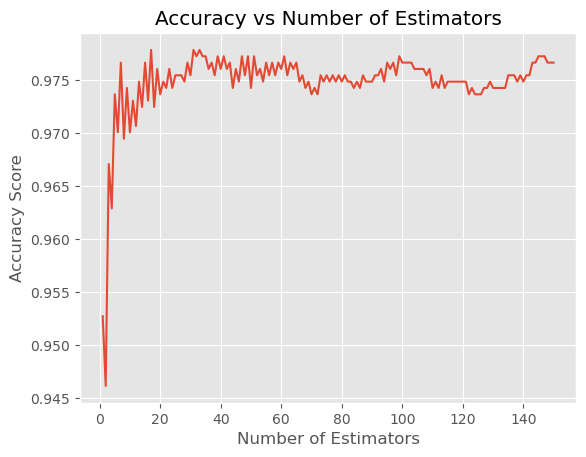

In [55]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [57]:
parameter = {'n_estimators': range(5, 41)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")


The best number of estimators is: 37


## Modeling: Random Forest (Word2Vec)

In [62]:
X = X_word2vec
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=1) 
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9413875598086124

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1448
           1       0.84      0.70      0.76       224

    accuracy                           0.94      1672
   macro avg       0.90      0.84      0.86      1672
weighted avg       0.94      0.94      0.94      1672



In [63]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)